**<center><h1>S-DISCO - Virtual screening</h1></center>**



---



# Software installation

Click the play button below to install all the prerequisites software. Should take ~2 minutes

In [ ]:
!wget https://github.com/gnina/gnina/releases/download/v1.0.3/gnina
!chmod +x gnina
!pip install py3Dmol
!apt install openbabel
!pip3 install rdkit

In [ ]:
# !wget https://git.durrantlab.com/jdurrant/binana/-/archive/2.1/binana-2.1.zip --no-check-certificate
# !unzip binana-2.1.zip
# !cp -r /content/binana-2.1/python/binana /content

In [ ]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
import py3Dmol
from IPython.display import display, HTML

from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Descriptors, PandasTools, QED
from rdkit.Chem.FilterCatalog import FilterCatalogParams, FilterCatalog
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import binana

from google.colab import files

def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = sys.__stdout__

RDLogger.DisableLog('rdApp.*')

In [ ]:
def top3_poses(docked_sdf, rec="rec.pdb", lig="lig.pdb", display=display):
    ids = ["Pose #1", "Pose #2", "Pose #3"]
    supplier = Chem.SDMolSupplier(docked_sdf)
    molecules = [Chem.MolToMolBlock(mol) for mol in supplier if mol is not None]
    scores = [mol.GetProp("minimizedAffinity") for mol in supplier if mol is not None]

    lig_ref = Chem.MolFromPDBFile(lig)
    # rmsd = [AllChem.CalcRMS(lig_ref, mol, map=lig_ref.GetSubstructMatch(mol)) for mol in supplier if mol is not None]

    html_str = '''
    <table class="center">
    <tr>
    <td><h2 style="text-align:center;">{0}</h2></td>
    <td><h2 style="text-align:center;">{1}</h2></td>
    <td><h2 style="text-align:center;">{2}</h2></td>
    </tr>
    <tr>
    <td id="{0}">{3}</td>
    <td id="{1}">{4}</td>
    <td id="{2}">{5}</td>
    </tr>
    </table>
    '''

    html_str = html_str.format(ids[0], ids[1], ids[2], scores[0], scores[1], scores[2])
    display(HTML(html_str))

    for i in range(3):
        viewer = py3Dmol.view(width=400, height=400)
        viewer.addModel(open('rec.pdb').read())
        viewer.setStyle({'cartoon':{},'stick':{'radius':0.15}})
        viewer.addModel(open('lig.pdb').read())
        viewer.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon'}})
        viewer.addModel(molecules[i])
        viewer.setStyle({'model':2},{'stick':{'colorscheme':'cyanCarbon'}})
        viewer.zoomTo({'model':1})
        viewer.insert(ids[i])
    return

#####

def CB_Gnina_pandas(input_sdf, active):
    temp = PandasTools.LoadSDF(input_sdf)
    temp["minimizedAffinity"] = pd.to_numeric(temp["minimizedAffinity"])
    temp = temp.sort_values("minimizedAffinity").drop_duplicates("ID")
    temp.index = range(len(temp))

    temp["Active"] = active
    temp[["MW", "LogP", "HBA", "HBD", "PSA", "RotB", "Arom", "Alerts", "PAINS"]] = 0

    smiles_list = []
    for rowid_temp in range(len(temp)):
        smiles_list.append(Chem.MolToSmiles(temp.loc[rowid_temp,"ROMol"]))
        temp.loc[rowid_temp, ["MW", "LogP", "HBA", "HBD", "PSA", "RotB", "Arom", "Alerts"]] = [round(i,2) for i in QED.properties(temp["ROMol"][rowid_temp])]

    temp["ROMol"] = smiles_list
    return temp


#####

def CB_AUC(data_x, data_y):
    calculated_auc = 0
    for i in range(len(data_x)-1):
        auc_temp = (data_y[i] + data_y[i+1]) * (data_x[i+1] - data_x[i]) / 2
        calculated_auc = calculated_auc + auc_temp
    return calculated_auc

In [ ]:
# !pip install hydride

# Part 1. Molecular docking...?

## Choose your PDB file

Choose your PDB crystallographic file from the [RCSB Protein Data Bank](https://www.rcsb.org/) or the [Protein Data Bank in Europe PDBe](https://www.ebi.ac.uk/pdbe/).

You need:
1. The PDB ID code of your crystallographic 3D structure of your protein of interest,
2. The main chain of the protein,
3. The Ligand ID code of the associated ligand.


Here, for the reference human structure from the protein modeling session - [glucocorticoid receptor beta](https://www.rcsb.org/structure/5UC1):
1. The PDB ID code is **5UC1**
2. Here, the main chain we want to study can be either A or B, but we will select the chain **A**.
3. The Ligand ID for the RU-486 is **486**

In [ ]:
#@markdown This block will download for you the crystallographic structure, and split the receptor and the ligand from the other elements. Press play once you have completed the information on the form below

pdb_id = "XXXX" # @param {type:"string"}
ligand_id = "XXX" # @param {type:"string"}
chain_id = "A" # @param {type:"string"}

!wget http://files.rcsb.org/download/{pdb_id}.pdb -O /content/downloaded.pdb
!grep -E "ATOM.*[A-Z][A-Z][A-Z] {chain_id}" downloaded.pdb > rec.pdb
!grep "{ligand_id} {chain_id}" downloaded.pdb > lig.pdb

# !hydride -i rec.pdb -o recH.pdb
# !hydride -i lig.pdb -o ligH.pdb

print("Receptor {} with ligand {} downloaded successfully".format(pdb_id, ligand_id))

## Run the docking

In [ ]:
!./gnina -r rec.pdb -l lig.pdb --autobox_ligand lig.pdb --seed 0 -o docked.sdf --cnn_scoring=none --no_gpu

In [ ]:
top3_poses("docked.sdf")

# Part 2. “Perspective will come in retrospect.” (Retrospective docking)

Retrospective docking using the DUD-E subset for Glucocorticoid receptor : [https://dude.docking.org/targets/gcr](https://dude.docking.org/targets/gcr) (Crystallographic structure = 3BQD)

Here, using Gnina, screening of:
*   258 active ligands
*   14903 decoys



In [ ]:
!wget https://github.com/cbedart/S-DISCO/raw/main/results_gr_sorted.pkl

In [ ]:
results_gr_sorted = pd.read_pickle("/content/results_gr_sorted.pkl")
results_gr_sorted

## Physicochemical descriptors

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
axs[0,0].hist(results_gr_sorted["MW"], bins=30, color='dodgerblue')
axs[0,0].set_title('Molecular weight')
axs[0,1].hist(results_gr_sorted["LogP"], bins=30, color='dodgerblue')
axs[0,1].set_title('LogP')
axs[1,0].hist(results_gr_sorted["HBA"], color='dodgerblue')
axs[1,0].set_title('Hydrogen bond acceptors')
axs[1,1].hist(results_gr_sorted["HBD"], color='dodgerblue')
axs[1,1].set_title('Hydrogen bond donors')
axs[0,2].hist(results_gr_sorted["RotB"], color='forestgreen')
axs[0,2].set_title('Rotatable bonds')
axs[1,2].hist(results_gr_sorted["PSA"], bins=30, color='forestgreen')
axs[1,2].set_title('Polar Surface Area')
plt.tight_layout()
plt.show()

## Score distribution

In [ ]:
plt.plot(results_gr_sorted["minimizedAffinity"], zorder=100)
plt.title("Distribution of Vina affinity score")
plt.xlabel("Compounds ranking")
plt.ylabel("Vina affinity score")
plt.axhline(0, color="grey", linestyle="dashed", linewidth=0.5)
plt.axhline(-5, color="grey", linestyle="dashed", linewidth=0.5)
plt.axhline(-10, color="grey", linestyle="dashed", linewidth=0.5)
plt.show()

In [ ]:
plt.plot(results_gr_sorted["minimizedAffinity"], zorder=100)
plt.title("Distribution of Vina affinity score - Log(X)")
plt.xscale("log")
plt.xlabel("Compounds ranking")
plt.ylabel("Vina affinity score")
plt.axhline(0, color="grey", linestyle="dashed", linewidth=0.5)
plt.axhline(-5, color="grey", linestyle="dashed", linewidth=0.5)
plt.axhline(-10, color="grey", linestyle="dashed", linewidth=0.5)
plt.show()

## Enrichment curve and enrichment factors

Enrichment Factor (EF):

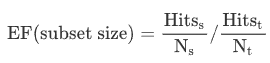

Where:
* Hits<sub>s</sub> = Number of active compounds in the sampled subset
* N<sub>s</sub> = Number of compounds in the sampled subset
* Hits<sub>t</sub> = Total number of active compounds
* N<sub>t</sub> = Total number of compounds

With a maximum Enrichment Factor of N<sub>t</sub> / Hits<sub>t</sub>

In [ ]:
top_percent = 1 # @param {type:"slider", min:0.5, max:100, step:0.5}

nb_actives = 258
enrich = [0]
for i in range(len(results_gr_sorted)):
    enrich.append(enrich[-1] + results_gr_sorted.loc[i,"Active"])

enrich_perc = [i/nb_actives for i in enrich]
enrich_random = [i/nb_actives for i in np.linspace(0,258,len(results_gr_sorted)+1)]
enrich_perfect = [i/nb_actives for i in list(range(0,258+1)) + list(np.repeat(258,len(results_gr_sorted)-258))]

enrich_xaxis = np.linspace(0, 1, len(enrich_perc))

plt.figure(figsize=[20,5])
plt.title("Enrichment curve - Retrospective docking")
plt.plot(enrich_xaxis, enrich_perc)
plt.plot(enrich_xaxis, enrich_random)
plt.plot(enrich_xaxis, enrich_perfect)

plt.xlabel("%database (False Positive Fraction - FPF)")
plt.ylabel("%actives (True Positive Fraction - TPF)")

plt.legend(["DUD-E - AUC {0}".format(round(CB_AUC(enrich_xaxis, enrich_perc),2)),"Ideal - AUC {0}".format(round(CB_AUC(enrich_xaxis, enrich_perfect),2)), "Random - AUC {0}".format(round(CB_AUC(enrich_xaxis, enrich_random),2))], loc="center right")
top_percent = top_percent / 100
top_id = round(len(results_gr_sorted)*top_percent)

plt.plot([enrich_xaxis[top_id], enrich_xaxis[top_id], enrich_xaxis[top_id]], [enrich_perc[top_id], enrich_random[top_id], enrich_perfect[top_id]], "ro", zorder=100, linestyle="dotted")

enrich_perc[top_id] / enrich_random[top_id]

plt.text(0.9, 0.2, "Enrichment factor at {0}% = {1}".format(top_percent*100, round(enrich_perc[top_id] / enrich_random[top_id], 2)), fontweight="bold", bbox=dict(facecolor='none', edgecolor='black', pad=4.0), horizontalalignment="center")
plt.text(0.9, 0.1, "Correspond to a maximum score of {0}".format(results_gr_sorted["minimizedAffinity"][top_id]), fontweight="bold", bbox=dict(facecolor='none', edgecolor='black', pad=4.0), horizontalalignment="center")

plt.show()

# Part 3. So… Prospective will come after retrospect?  (Prospective docking)

**Step #1** = Setup your protein structure. We use here the structures provided on the DUD-E website.

Sometimes you also have to add hydrogens, but Vina-derived software does not take them into account.

You will also download your ligands in the SMILES format = "PS2_ligands.smi"

In [ ]:
!wget https://raw.githubusercontent.com/cbedart/S-DISCO/main/receptor.pdb
!wget https://raw.githubusercontent.com/cbedart/S-DISCO/main/crystal_ligand.mol2
!wget https://raw.githubusercontent.com/cbedart/S-DISCO/main/PS2_ligands.smi

**Step #2** = Generate the 3D coordinates of the ligands. You have to generate the tautomers, protomers, charges, etc. but we will avoid this today.

Sometimes you also have to add hydrogens, but Vina-derived software does not take them into account.

In [ ]:
writer = Chem.SDWriter("PS2_ligands.sdf")

with open("PS2_ligands.smi", 'r') as file:
    for line in file:
        smiles = line.strip().split()[0]
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            mol = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol, AllChem.ETKDG())
            AllChem.UFFOptimizeMolecule(mol)
            name = line.strip().split()[1]
            mol.SetProp("_Name", name)
            writer.write(mol)
        else:
            print(f"Could not process SMILES: {smiles}")

writer.close()
print("Done !")

**Step #3** = Run the virtual screening. The box is setup automatically around the crystallized ligand, but ideally you have to setup your own box. It's very important to keep the same parameters validated in the retrospective screening.

Since this step will take ~15 min as Colab is quite slow, the next block will mimic the output of the screening and download the expected results. You can find on the left side in the files the "PS2_ligands_docked.sdf" and the "PS2_ligands_docked_bestposes.sdf" results files.

In [ ]:
# !./gnina -r receptor.pdb -l PS2_ligands.sdf --autobox_ligand crystal_ligand.mol2 --autobox_add 8 --num_modes=3 -o PS2_ligands_docked.sdf --cnn_scoring=none --no_gpu

!wget https://raw.githubusercontent.com/cbedart/S-DISCO/main/PS2_output.txt >/dev/null 2>&1
!wget https://raw.githubusercontent.com/cbedart/S-DISCO/main/PS2_ligands_docked.sdf >/dev/null 2>&1
!wget https://raw.githubusercontent.com/cbedart/S-DISCO/main/PS2_ligands_docked_bestposes.sdf
!wget
!cat PS2_output.txt

Press "play" below to download the results on your laptop:

In [ ]:
files.download('crystal_ligand.mol2')
files.download('receptor.pdb')
files.download('PS2_ligands_docked_bestposes.sdf')